## Observations and Insights 

In [1]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import sem
import numpy as np
%matplotlib inline

In [2]:
# First step is to save the path to the csv files that I am going to use
mouse_metadata_path = "data/Mouse_metadata.csv"
study_results_path = "data/Study_results.csv"

# Read the mouse data and the study results
mouse_metadata_df = pd.read_csv(mouse_metadata_path)
study_results_df = pd.read_csv(study_results_path)
# Now I want to see what the dataframes look like so I will print out the first few rows of each
mouse_metadata_df.head()

,Mouse ID,Drug Regimen,Sex,Age_months,Weight (g)
0,k403,Ramicane,Male,21,16
1,s185,Capomulin,Female,3,17
2,x401,Capomulin,Female,16,15
3,m601,Capomulin,Male,22,17
4,g791,Ramicane,Male,11,16


In [3]:
study_results_df.head()

,Mouse ID,Timepoint,Tumor Volume (mm3),Metastatic Sites
0,b128,0,45.0,0
1,f932,0,45.0,0
2,g107,0,45.0,0
3,a457,0,45.0,0
4,c819,0,45.0,0


In [4]:
# # Combine the data into a single dataset
# Before merging the dataframes together I want to check what type of join to do to make sure that I do not lose any data
# To do this I will count the number of unique Mouse IDs in each dataframe and compare them 
unique_meta = mouse_metadata_df['Mouse ID'].unique()
unique_study = study_results_df['Mouse ID'].unique()
print(f"{len(unique_meta)} {len(unique_study)}")

249 249


In [5]:
# Since the number of Mouse IDs matches I can use an inner join and I will not lose any data
merge_df = pd.merge(study_results_df, mouse_metadata_df, on="Mouse ID")
# Display the data table for preview
merge_df.head()

,Mouse ID,Timepoint,Tumor Volume (mm3),Metastatic Sites,Drug Regimen,Sex,Age_months,Weight (g)
0,b128,0,45.000000,0,Capomulin,Female,9,22
1,b128,5,45.651331,0,Capomulin,Female,9,22
2,b128,10,43.270852,0,Capomulin,Female,9,22
3,b128,15,43.784893,0,Capomulin,Female,9,22
4,b128,20,42.731552,0,Capomulin,Female,9,22


In [6]:
# Checking the number of mice.
number_mice = merge_df['Mouse ID'].unique()
print(f"There were {len(number_mice)} mice used in this study")

There were 249 mice used in this study


In [7]:
# Now I want to remove any rows where the same Mouse ID appears multiple times for the same Timepoint
# To do that I will first groupby these 2 columns 
mice_grouped_df = merge_df.groupby(["Mouse ID", "Timepoint"])

# Now I want to count how many times the Mouse ID appears for each Timepoint
# I choose to use the column header sex but any column would have worked 
duplicate_count = mice_grouped_df["Sex"].count()

duplicate_entry_df = pd.DataFrame(duplicate_count)
# Here I am creating a new dataframe with only the Mouse IDs that are in the same Timepoint more than once 
duplicates_df = duplicate_entry_df.loc[(duplicate_entry_df["Sex"] >= 2)]
duplicates_df

Sex
Mouse ID Timepoint     
g989     0            2
         5            2
         10           2
         15           2
         20           2

In [8]:
# This shows me that only one Mouse ID has multiple of the same Timepoints
# This data was clearly entered in incorrectly so I am going to delete it, but before doing so I want to view all . . . 
# the data associated with this Mouse ID
duplicates_index = duplicates_df.index
duplicate_mouse_data = merge_df.loc[(merge_df["Mouse ID"] == duplicates_index[0][0])]
duplicate_mouse_data

,Mouse ID,Timepoint,Tumor Volume (mm3),Metastatic Sites,Drug Regimen,Sex,Age_months,Weight (g)
860,g989,0,45.000000,0,Propriva,Female,21,26
861,g989,0,45.000000,0,Propriva,Female,21,26
862,g989,5,48.786801,0,Propriva,Female,21,26
863,g989,5,47.570392,0,Propriva,Female,21,26
864,g989,10,51.745156,0,Propriva,Female,21,26
865,g989,10,49.880528,0,Propriva,Female,21,26
866,g989,15,51.325852,1,Propriva,Female,21,26
867,g989,15,53.442020,0,Propriva,Female,21,26
868,g989,20,55.326122,1,Propriva,Female,21,26
869,g989,20,54.657650,1,Propriva,Female,21,26


In [9]:
# Create a clean DataFrame by dropping the duplicate mouse by its ID.
merge_df = merge_df.loc[(merge_df["Mouse ID"] != duplicates_index[0][0])]

In [10]:
# Checking the number of mice in the clean DataFrame.
no_duplicate = merge_df['Mouse ID'].unique()
print(f"The correct number of mice used in this study is {len(no_duplicate)}. Certain values were entered incorrectly and had to be removed")

The correct number of mice used in this study is 248. Certain values were entered incorrectly and had to be removed


## Summary Statistics

In [11]:
# Generate a summary statistics table of mean, median, variance, standard deviation, and SEM of the tumor volume for each regimen
# Use groupby and summary statistical methods to calculate the following properties of each drug regimen: 
# mean, median, variance, standard deviation, and SEM of the tumor volume. 
# Assemble the resulting series into a single summary dataframe.
regimen_grouped_df = merge_df.groupby(["Drug Regimen"])
tumor_mean = regimen_grouped_df['Tumor Volume (mm3)'].mean()
tumor_median = regimen_grouped_df['Tumor Volume (mm3)'].median()
tumor_sd = regimen_grouped_df['Tumor Volume (mm3)'].std()
tumor_var = tumor_sd**2
tumor_sem = regimen_grouped_df['Tumor Volume (mm3)'].sem()

tumor_statistics_df = pd.DataFrame(tumor_mean.map("{:.2f}".format))
tumor_statistics_df["Tumor Vol Median"] = tumor_median.map("{:.2f}".format)
tumor_statistics_df["Tumor Vol SD"] = tumor_sd.map("{:.2f}".format)
tumor_statistics_df["Tumor Vol Var"] = (tumor_var).map("{:.2f}".format)
tumor_statistics_df["Tumor Vol SEM"] = (tumor_sem).map("{:.2f}".format)
tumor_statistics_df = tumor_statistics_df.rename(columns={"Tumor Volume (mm3)":"Tumor Vol Mean"})

tumor_statistics_df

,Tumor Vol Mean,Tumor Vol Median,Tumor Vol SD,Tumor Vol Var,Tumor Vol SEM
Drug Regimen,,,,,
Capomulin,40.68,41.56,4.99,24.95,0.33
Ceftamin,52.59,51.78,6.27,39.29,0.47
Infubinol,52.88,51.82,6.57,43.13,0.49
Ketapril,55.24,53.70,8.28,68.55,0.60
Naftisol,54.33,52.51,8.13,66.17,0.60
Placebo,54.03,52.29,7.82,61.17,0.58
Propriva,52.32,50.45,6.62,43.85,0.54
Ramicane,40.22,40.67,4.85,23.49,0.32
Stelasyn,54.23,52.43,7.71,59.45,0.57


## Bar and Pie Charts

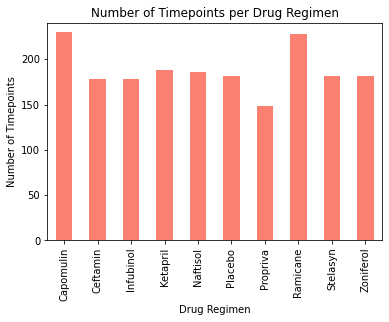

In [12]:
# Generate a bar plot showing the total number of timepoints for all mice tested for each drug regimen using Pandas.
tumor_count = regimen_grouped_df['Timepoint'].count()
tumor_count.plot(kind="bar", facecolor="salmon", ylabel="Number of Timepoints", title="Number of Timepoints per Drug Regimen", ylim =(0, max(tumor_count)+10) )
# To remove extra text
plt.show()

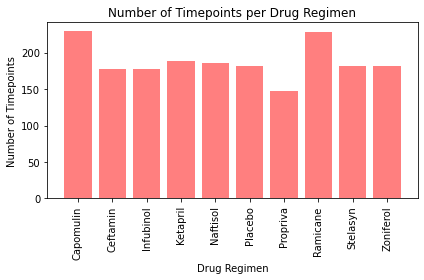

In [13]:
# Generate a bar plot showing the total number of timepoints for all mice tested for each drug regimen using pyplot.
x_axis = np.arange(len(regimen_grouped_df))
plt.bar(x_axis, tumor_count, color='r', alpha=0.5, align="center")
# Here I am taking the index of the tumor statistics dataframe to get a list of drug regimens . . . 
# So that I can put this as the ticks for the x- axis
regimen_names = tumor_statistics_df.index
plt.xticks(x_axis, regimen_names, rotation='90')

ylim =(0, max(tumor_count)+10)

plt.title("Number of Timepoints per Drug Regimen")
plt.ylabel("Number of Timepoints")
plt.xlabel("Drug Regimen")

plt.tight_layout()
plt.show()

In [ ]:
# # Generate a pie plot showing the distribution of female versus male mice using Pandas


In [ ]:
# Generate a pie plot showing the distribution of female versus male mice using pyplot


## Quartiles, Outliers and Boxplots

In [ ]:
# Calculate the final tumor volume of each mouse across four of the treatment regimens:  
# Capomulin, Ramicane, Infubinol, and Ceftamin

# Start by getting the last (greatest) timepoint for each mouse


# Merge this group df with the original dataframe to get the tumor volume at the last timepoint


In [ ]:
# Put treatments into a list for for loop (and later for plot labels)


# Create empty list to fill with tumor vol data (for plotting)


# Calculate the IQR and quantitatively determine if there are any potential outliers. 

    
    # Locate the rows which contain mice on each drug and get the tumor volumes
    
    
    # add subset 
    
    
    # Determine outliers using upper and lower bounds
    

In [ ]:
# Generate a box plot of the final tumor volume of each mouse across four regimens of interest


## Line and Scatter Plots

In [ ]:
# Generate a line plot of tumor volume vs. time point for a mouse treated with Capomulin


In [ ]:
# Generate a scatter plot of average tumor volume vs. mouse weight for the Capomulin regimen


## Correlation and Regression

In [ ]:
# Calculate the correlation coefficient and linear regression model 
# for mouse weight and average tumor volume for the Capomulin regimen
